**Museum of Modern Art Collection Analysis**

https://github.com/gracecombe/MOMAproject

This project explores the Museum of Modern Art's (MoMA) art collection in New York, using data from the museum's website (current through 2017) and stored on Kaggle.  The primary goal is to investigate MoMA's attitudes and patterns regarding demographic representation and acquisition trends over time.

There are two CSV files used in this analysis. The first, artists.csv, has 15,091 records, each representing an individual artist regardless of how many works they have in the collection. It includes information such as the artist's name, nationality, gender, birth and death years, and a unique ID number. The second file, artworks.csv, has 130,262 records, each corresponding to a single artwork. It includes the artwork's title, the artist’s ID and name, date (year of creation), medium, dimensions, acquisition date, credit (how the artwork was acquired), department, classification, and other dimensional/size variables.

The questions being asked in this project are about the representation of genders, nationalities, and mediums in the collection as well as the relationship between a piece of art’s creation date/an artist’s death date and when the museum acquired their work. The ultimate goal is to discover the reasoning behind the spike in acquiring artworks by French male artists in the 1960s.

This project asks questions about how different genders, nationalities, and artistic mediums are represented in the collection, and examines how the timing of an artwork's creation or an artist's death date relates to the museum's acquisition decisions. Ultimately, it aims to discover the reasoning behind a notable spike in the acquisition of works by French male artists during the 1960s. These are the questions answered in this analysis:
- To what extent does the collection feature artworks created by artists of different genders and nationalities? How have these demographics changed over time (by acquisition decade)?
- What is the distribution of creation dates in this collection?
- How have the mediums acquired by the museum changed over time?
- How long after an artist's death does the museum typically acquire their work?
- How long after a piece is created does the museum typically acquire it?
- What caused the spike of acquisitions in artworks by French artists, male artists, and in albumen silver print pieces in the 1960s?

In [10]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [11]:
# load data
artists = pd.read_csv("https://raw.githubusercontent.com/gracecombe/MOMAproject/refs/heads/main/artists.csv")
artworks = pd.read_csv("https://raw.githubusercontent.com/gracecombe/MOMAproject/refs/heads/main/artworks.csv")

I started cleaning the data by renaming some of the columns in both data frames to make their meaning clearer.

In [12]:
# rename name column in artist df for clarity
artists.rename(columns = {'Name': 'Artist Name'}, inplace = True)
# rename columns in artworks df for clarity
artworks.rename(columns = {'Name': 'Artist Name', 'Date': 'Creation Date', 'Credit':'Source'}, inplace = True)

I checked if how many missing values there were in the artists data frame. There are a lot of missing values in the Death Year column (about 70%), but I thought this made sense considering many artists are likely still alive. There were some missing values in the Nationality, Gender, and Birth Year columns, but I didn't think these would detract from any analyses.

In [13]:
# check that all artists have id and name
print(f"Count of missing values:\n{artists.apply(lambda x: x.isna().sum())}")
print(f"Amount of missing values as proportions of rows:\n{artists.apply(lambda x: x.isna().mean())}")

Count of missing values:
Artist ID          0
Artist Name        0
Nationality     2488
Gender          3072
Birth Year      3854
Death Year     10512
dtype: int64
Amount of missing values as proportions of rows:
Artist ID      0.000000
Artist Name    0.000000
Nationality    0.164866
Gender         0.203565
Birth Year     0.255384
Death Year     0.696574
dtype: float64


I checked how many missing values there were in the artworks data frame. I dropped missing values from the Artist ID column, since this is the column I will be using to join the two data frames. I dropped the Dimensions, Catalogue, Department, Classification, Object Number, Diameter, Circumference, Height, Length, Width, Depth, Weight, and Duration columns from this data frame because they were not relevant to my analysis and most of these columns had a huge proportion of missing values (up to nearly 100% in some columns). I also removed Artist Name because it is in the artists data frame, which I will be joining with this data frame.

In [14]:
# check if any artworks are missing artist id and name
artworks.apply(lambda x: x.isna().sum())
# there are 1460 artworks missing artist id/name -- drop NA's in Artist ID (will be mergining on this column)
artworks = artworks.dropna(subset = ['Artist ID'])
# check that it worked and get counts/proportions of missing values in other columns
print(f"Count of missing values:\n{artworks.apply(lambda x: x.isna().sum())}")
print(f"Amount of missing values as proportions of rows:\n{artworks.apply(lambda x: x.isna().mean())}")
artworks = artworks[['Artwork ID', 'Title', 'Artist ID', 'Creation Date', 'Medium', 'Acquisition Date', 'Source']]

Count of missing values:
Artwork ID                 0
Title                     26
Artist ID                  0
Artist Name                0
Creation Date           1790
Medium                 11569
Dimensions             10960
Acquisition Date        5308
Source                  2866
Catalogue                  0
Department                 0
Classification             0
Object Number              0
Diameter (cm)         127409
Circumference (cm)    128792
Height (cm)            17955
Length (cm)           128071
Width (cm)             18845
Depth (cm)            117906
Weight (kg)           128504
Duration (s)          125917
dtype: int64
Amount of missing values as proportions of rows:
Artwork ID            0.000000
Title                 0.000202
Artist ID             0.000000
Artist Name           0.000000
Creation Date         0.013897
Medium                0.089820
Dimensions            0.085092
Acquisition Date      0.041211
Source                0.022251
Catalogue             0.0

I wanted to get a sense of the distribution of birth and death years, so I looked at basic summary statistics and histograms.

In [15]:
# look at basic summary statistics of artists' birth and death years
artists[['Birth Year', 'Death Year']].describe().loc[['mean', 'min', '50%', 'max']]

,Birth Year,Death Year
mean,1930.852719,1974.287399
min,1730.000000,1795.000000
50%,1936.000000,1980.000000
max,2012.000000,2017.000000


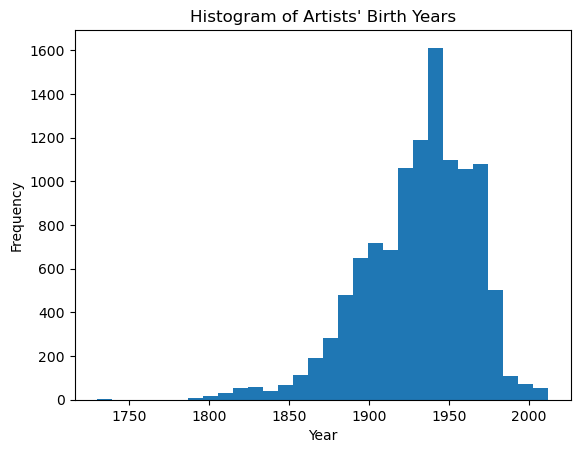

In [16]:
# visualize distribution of artists' birth years with a histogram
artists['Birth Year'].plot(kind = 'hist', bins = 30)
# add title and axis labels
plt.title('Histogram of Artists\' Birth Years')
plt.xlabel('Year')
plt.ylabel('Frequency')
# show plot
plt.show()

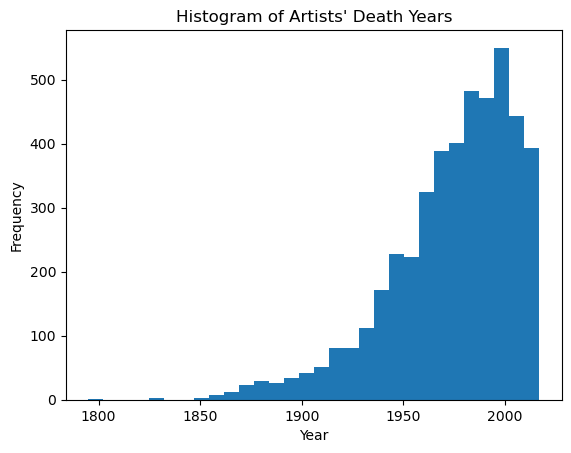

In [17]:
# visualize distribution of death years with a historgram
artists['Death Year'].plot(kind = 'hist', bins = 30)
# add title and axis labels
plt.title('Histogram of Artists\' Death Years')
plt.xlabel('Year')
plt.ylabel('Frequency')
# show plot
plt.show()

In my analysis, I wanted to answer some questions at an artist level, but if an artwork was done by multiple artists, there was only one row for that piece. I split the Artist ID column on the comma and exploded the rows so that a piece done by multiple artists would have one row per artist. I did this because if a piece was done by a male artist and a female artist, for example, I wanted the piece to count as representing male and female artists. This made it so my counts of gender and nationalities would be an accurate, fair representation of the collection.

In [18]:
# split artist ids by comma in artworks so there is only one id per artwork (one row per artist per artwork)
# make a copy of artworks df
artworks_copy = artworks.copy()
# split Artist ID column on comma
artworks_copy['Artist ID'] = artworks['Artist ID'].str.split(',')
# explode data to have new row per item
artworks_exploded = artworks_copy.explode('Artist ID', ignore_index = True)

I did some more data cleaning in prepartation for my analysis, including normalizing the values in the Gender and Nationality columns for consistency and changing the Birth Year and Death Year columns to be datetime objects, since they represent dates. Since these were years and not dates, I set the Birth Year to the first of the year (the earliest possible date that year to be born) and the Death Year to the last of the year (the latest possible date that year to have died). I also created two new columns, Birth Decade and Death Decade, which are the decades of the Birth Year and Death Year columns respectively. I made these columns for my trend analyses; I wanted to analyze the data based on decade rather than year because the data covers about a century. Grouping by decade helped to reduce noise and smooth out trends, allowing for more meaningul interpretations. 

In [19]:
# clean Gender and Nationality columns for consistency of values
artists['Gender'] = artists.apply(lambda row: 'NaN' if pd.isna(row['Gender']) else ('Male' if row['Gender'] in ['Male', 'male'] else ('Female' if row['Gender'] == 'Female' else row['Gender'])), axis=1)
artists['Nationality'] = artists.apply(lambda row: 'Nationality Unknown' if pd.isna(row['Nationality']) else ('Nationality Unknown' if row['Nationality'] in ['Nationality unknown', 'Nationality Unknown', 'nationality unknown'] else row['Nationality']), axis=1)
# change Birth and Death Year to type date
artists['Birth Year'] = artists['Birth Year'].apply(lambda x: pd.to_datetime(f"{int(x)}-01-01") if pd.notna(x) else np.nan)
artists['Death Year'] = artists['Death Year'].apply(lambda x: pd.to_datetime(f"{int(x)}-12-31") if pd.notna(x) else np.nan)
# get birth and death decade to show trends over time
artists['Birth Decade'] = artists['Birth Year'].apply(lambda x: (x.year//10)*10 if pd.notna(x) else np.nan)
artists['Death Decade'] = artists['Death Year'].apply(lambda x: (x.year//10)*10 if pd.notna(x) else np.nan)

In the exploded artworks data frame, I changed the Artist ID column to be an integer rather than an object because I used that column to join with the artists data frame, where the Artist ID column was an integer.

In [20]:
# change Artist ID in artworks to type int from object to be able to merge with artists
#artworks_exploded['Artist ID'] = artworks_exploded['Artist ID'].fillna(0).astype('int64')
artworks_exploded['Artist ID'] = artworks_exploded['Artist ID'].astype('int64')

I merged the data frames with a left join of artists onto the artworks data frame. I did a left join this way because I wanted each row of the artwork data frame to have the demographic information of the corresponding artist.

In [21]:
# join the tables
df = pd.merge(artworks_exploded, artists, how = 'left', on = 'Artist ID')

I changed Acquisition Date to a datetime object, since it represents dates. I made an Acquisition Decade column (the decade from Acquisition Date), since I will be doing my analyses over decades rather years. 

In [22]:
# change Acquisition Date to type date
df['Acquisition Date'] = pd.to_datetime(df['Acquisition Date'], errors = "coerce")
# get Acquisition Decade to show trends over time
df['Acquisition Decade'] = df['Acquisition Date'].apply(lambda x: (x.year//10)*10 if pd.notna(x) else np.nan)

**To what extent does the collection feature artworks created by artists of different genders and nationalities?**

My first question is related to the representation of nationality and gender in the collection. I wanted to look at this from an artwork level perspective (rather than an artist level perspective) because I wanted to understand the prominence of different groups rather than simply the presence. For example, an artist level analysis could conclude there are 100 female artists and 100 male artist represented in a collection. However, an artwork level analysis could conclude that same collection has 500 artworks by men and 100 artworks by women. I wanted to be able to see this disparity in representation volume, if one was present.

I began by grouping the data by Gender and Nationality to get the number of artworks in the MoMA collection of each combination in order to effectively analyse how representation varies across different demographic groups. 

In [23]:
# create a df of counts of artists grouped by gender and nationality
# set Gender as the index
gender_nat_count = df.groupby(['Gender', 'Nationality']).size().reset_index().set_index(['Gender'])

I created individual data frames filtered for each gender, and unknown gender, to help with creating the plots. I kept unknown gender and nationality values in the data because there was a significant portion of each missing (see above - about 20% and 16% respectively). I thought it was important to have this transparency and treat the missing values as categories; I was also interested in seeing if there were trends in the acquisition of artworks by artists of unknown genders and nationalities.

In [24]:
# create a df for female artists
female_gn_count = gender_nat_count.loc['Female']
# set Nationality as the index
female_gn_count = female_gn_count.reset_index(drop = True).set_index(['Nationality'])
# create a df for male artists
male_gn_count = gender_nat_count.loc['Male']
# set Nationality as the index
male_gn_count = male_gn_count.reset_index(drop = True).set_index(['Nationality'])
# create a df for NaN/unknown gender
nan_gn_count = gender_nat_count.loc['NaN']
# set Nationality as the index
nan_gn_count = nan_gn_count.reset_index(drop = True).set_index(['Nationality'])

Since there are 122 nationalities, I thought it would be most effective to compare only the top 10 most represented nationalities  of each gender to answer this question.

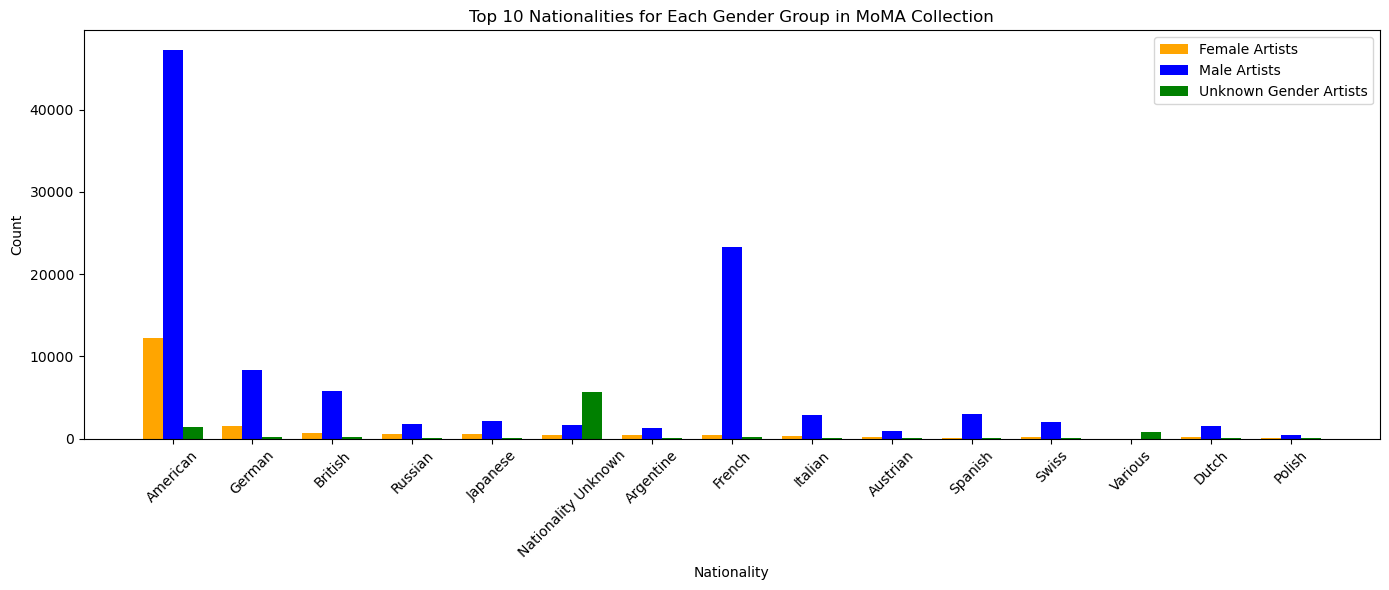

In [25]:
# get the top 10 most represented nationalities from the female and male dfs
female_top = female_gn_count.sort_values(by = 0, ascending = False).head(10)
male_top = male_gn_count.sort_values(by = 0, ascending = False).head(10)
nan_top = nan_gn_count.sort_values(by = 0, ascending = False).head(10)
# combine unique nationalities from all top 10 lists
all_nationalities = pd.Index(
    list(female_top.index) + list(male_top.index) + list(nan_top.index)
).unique()
# reindex each series to include all nationalities from combined list (fill missing with 0)
female_data = female_gn_count.reindex(all_nationalities, fill_value=0)[0]
male_data = male_gn_count.reindex(all_nationalities, fill_value=0)[0]
nan_data = nan_gn_count.reindex(all_nationalities, fill_value=0)[0]
# plot data
index = np.arange(len(all_nationalities))
bar_width = 0.25
fig, ax = plt.subplots(figsize=(14, 6))
# set up spacing and clustering of bars
ax.bar(index - bar_width, female_data, width=bar_width, label="Female Artists", color="orange")
ax.bar(index, male_data, width=bar_width, label="Male Artists", color="blue")
ax.bar(index + bar_width, nan_data, width=bar_width, label="Unknown Gender Artists", color="green")
# add axis labels and title
ax.set_xlabel('Nationality')
ax.set_ylabel('Count')
ax.set_title('Top 10 Nationalities for Each Gender Group in MoMA Collection')
# space and rotate x axis labels for readability
ax.set_xticks(index)
ax.set_xticklabels(all_nationalities, rotation=45)
# add legend
ax.legend()
# show plot
plt.tight_layout()
plt.show()

**The collection is primarly composed of artworks by male artists, who are significantly better represented than female artists and those with unknown gender. In terms of nationality, there are the most pieces by American artists, followed by French, German, artists of unknown nationality, and British artists. Among female artists, American women have the greatest representation in the collections. When an artist's nationality is unknown, their gender is often unknown as well, suggesting these may be artworks by unknown artists.**

**How have these demographics changed over time (by acquisition decade)?**

Again, I wanted to answer this question at an artwork level to understanding representation volume rather than presence, and I kept the artworks by artists of unknown genders and nationalities to see if there were any trends in those categories.

Text(0.5, 0, 'Decade')

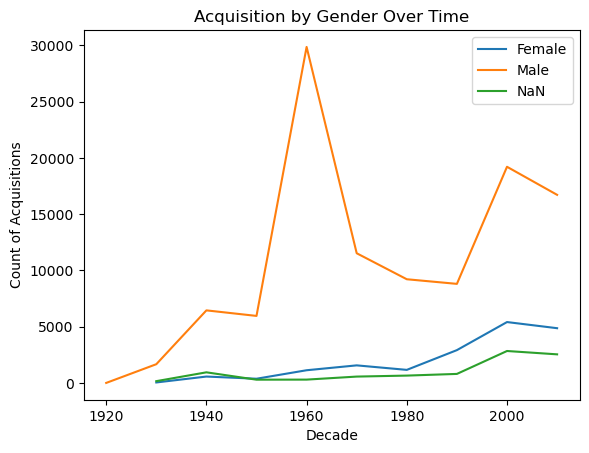

In [26]:
# create a df of counts of artworks by female artists acquired each decade
female_acq_trend = df[df['Gender'] == 'Female'].groupby(['Acquisition Decade']).size().reset_index()
# rename count column to Female
female_acq_trend.rename(columns = {0: 'Female'}, inplace = True)
# create a df of counts of artwoks by male artists acquired each decade
male_acq_trend = df[df['Gender'] == 'Male'].groupby(['Acquisition Decade']).size().reset_index()
# rename count column to Male
male_acq_trend.rename(columns = {0: 'Male'}, inplace = True)
# create a df of counts of artworks by NaN/unknown artists acquired each decade
nan_acq_trend = df[df['Gender'] == 'NaN'].groupby(['Acquisition Decade']).size().reset_index()
# rename count column to NaN
nan_acq_trend.rename(columns = {0: 'NaN'}, inplace = True)
# plot female data first and add title
first_plot = female_acq_trend.plot(x = 'Acquisition Decade', y = 'Female', title = 'Acquisition by Gender Over Time')
# set y axis label
first_plot.set_ylabel('Count of Acquisitions')
# plot male data onto female plot
male_acq_trend.plot(x = 'Acquisition Decade', y = 'Male', ax = first_plot)
# plot NaN data onto female plot
nan_acq_trend.plot(x = 'Acquisition Decade', y = 'NaN', ax = first_plot)
# set x axis label
first_plot.set_xlabel('Decade')

**Throughout MoMA's existence, the acquisition of artworks by male artists has always been greater than that of female artists and artists with unknown gender. There was a significant spike in the acquisition of artworks by male artists in the 1960s and another increase in the 2000s. Other than in the 1960s, the acquisition of artworks by female artists and artists with unknown gender follow a similar trend to that of male artists, but at lower levels. Overall, the acquisition of artworks by female artists is slightly greater than the acquisition of artworks by artists with unknown gender.**

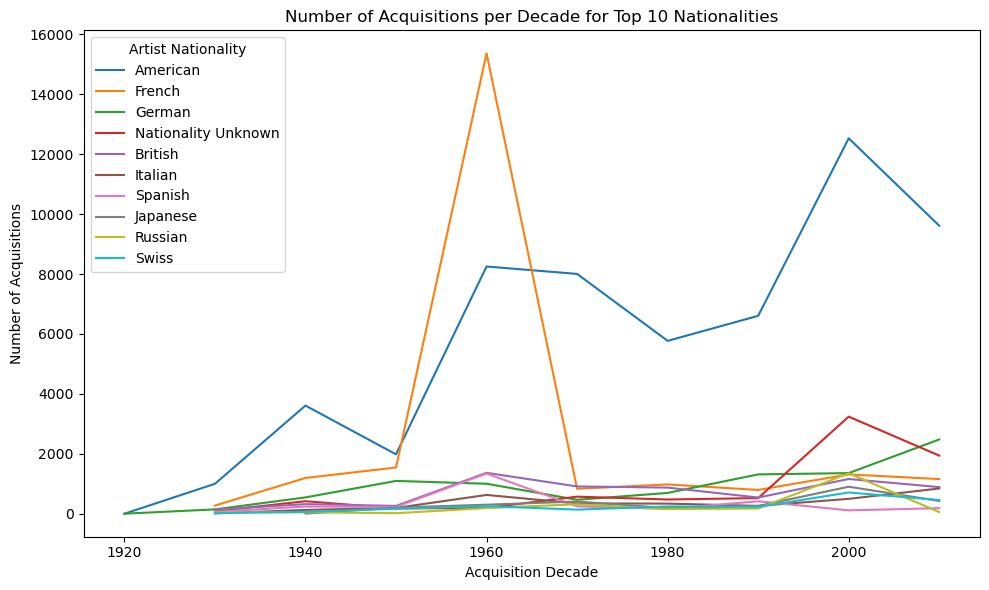

In [27]:
# create a new df of number of acquisitions by nationality each decade
acqs_by_nationality = df.groupby(['Nationality', 'Acquisition Decade']).size().reset_index(name = 'Num_Acquisitions')
# create a df of counts of top 10 nationalities overall
top_10_nat = acqs_by_nationality.groupby('Nationality')['Num_Acquisitions'].sum().nlargest(10).index
# filter acqs_by_nationality to only include top 10 nationalities
filtered_acqs = acqs_by_nationality[acqs_by_nationality['Nationality'].isin(top_10_nat)]
# plot the data
plt.figure(figsize = (10,6))
# for each of the top 10 nationalities, plot the data in a line plot
for nationality in top_10_nat:
    nat_data = filtered_acqs[filtered_acqs['Nationality'] == nationality]
    plt.plot(nat_data['Acquisition Decade'], nat_data['Num_Acquisitions'], label = nationality)
# add title, legend, and axis labels
plt.title('Number of Acquisitions per Decade for Top 10 Nationalities')
plt.xlabel('Acquisition Decade')
plt.ylabel('Number of Acquisitions')
plt.legend(title = 'Artist Nationality')
# show plot
plt.tight_layout()
plt.show()

**In every decade except for the 1960s, MoMA has acquired more artworks by American artists than any other nationality. In the 1960s, there was spike in the acquisition of artworks by French artists that surpassed the acquisition of artworks by American artists. Over time, MoMA appears to have broadened its acquisition focus since many other nationalities experienced their peaks in acquisitions around 2000.**

I thought it was very interesting that there was a spike in artworks by French artists acquired in the 1960s that seemed to correspond with the spike in artworks by male artists acquired in the 1960s.

**What is the distribution of creation dates in this collection?**

I wanted to answer this question because I thought there may be a relationship between acquisition date and creation date so I wanted to compare the distributions to see if there was an explanation for the spike in the 1960s.

I created a new column, Year Created, that is the year from the Creation Date column. The formatting in the Creation Date column was inconsistent - there were year ranges, circa dates, etc - so I decided to use the first 4 digits as the creation year. I converted this into a datetime object since it represents a date and created a new column, Decade Created, to plot the distribution of creation decades. I used decade again rather than year to reduce the noise from individual years and show a more general trend.

In [28]:
# clean the creation date column since formatting is not consistent (date ranges, circa, etc) -- do this by getting the first four digits
df['Year Created'] = df['Creation Date'].str.extract(r'(\d{4})')
# convert from string to datetime
df['Year Created'] = pd.to_datetime(df['Year Created'], errors = "coerce")
# get decade from year created to plot trend
df['Decade Created'] = df['Year Created'].apply(lambda x: (x.year//10)*10 if pd.notna(x) else np.nan)

I used a histogram to visualize this distribution.

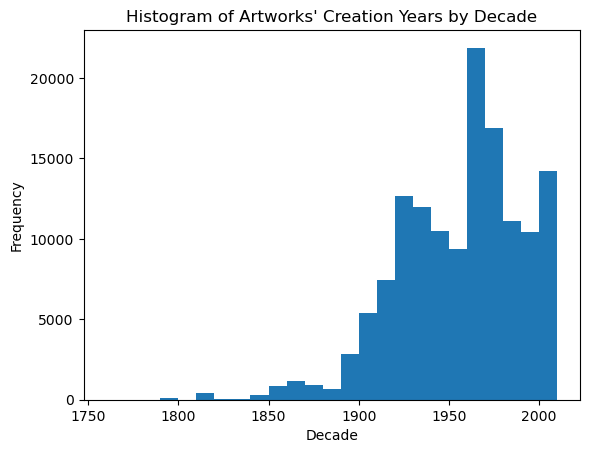

In [29]:
# visualize distribution of death years with a historgram
df['Decade Created'].plot(kind = 'hist', bins = 25)
# add title and axis labels
plt.title('Histogram of Artworks\' Creation Years by Decade')
plt.xlabel('Decade')
plt.ylabel('Frequency')
# show plot
plt.show()

**The distribution of creation dates in the MoMA collection is left skewed, with the majority of the artworks being created in the mid-to-late 1900s and fewer works being created in the 1800s. The histogram has three notable time periods with the highest frequencies around the 1920s, 1960s, and 2010s, suggesting these were periods of increased artistic activity or focused acquisition by MoMA. The distribution highlights MoMA's emphasis on modern and contemporary art, with a significant amount of works from the past century.**

**How have the mediums acquired by the
museum changed over time?**

In order to answer this question, I created a pivot table with Acquisition Decade as the index, Medium as the columns, and the values were the number of artworks. Since there are so many mediums, I decided it would be most effective to plot only the top 10 mediums. I found the top 10 mediums across all decades because having a constant set of mediums to track over time gave a stable frame of reference across all decades.

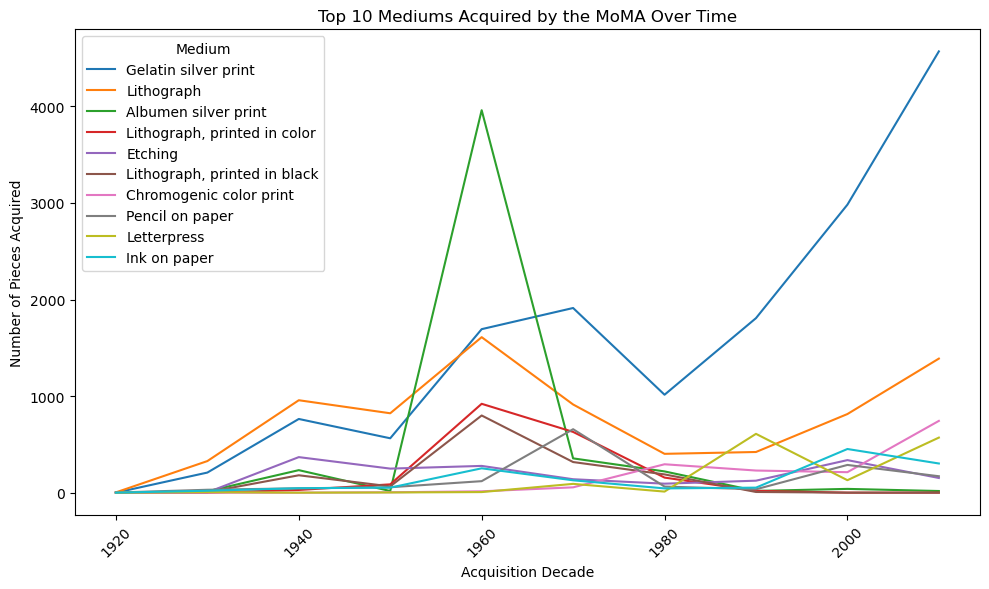

In [30]:
# create a df of counts of mediums each decade
medium_counts = df.groupby(['Acquisition Decade', 'Medium']).size().reset_index(name = 'Piece Count')
# pivot the data to get a count for each medium/decade combination and better select top mediums/make visualization
pivot_df = medium_counts.pivot_table(index = 'Acquisition Decade', columns = 'Medium', values = 'Piece Count', aggfunc = 'sum', fill_value = 0)
# get top 10 mediums by total piece count across all decades
top_10_mediums = pivot_df.sum().sort_values(ascending = False).head(10).index
# filter pivot table to only have top 10 mediums
pivot_top_10 = pivot_df[top_10_mediums]
# plot data
pivot_top_10.plot(kind = 'line', figsize = (10,6))
# add title, legend, and axis labels
plt.xlabel('Acquisition Decade')
plt.ylabel('Number of Pieces Acquired')
plt.title('Top 10 Mediums Acquired by the MoMA Over Time')
plt.legend(title = 'Medium', loc = 'upper left')
# rotate x axis labels for readability
plt.xticks(rotation = 45)
# show plot
plt.tight_layout()
plt.show()

**Over time, the volume of the top 10 mediums acquired by MoMA have changed significantly. Until the 1950s, the acquisition of all of the mediums followed similar trends, which suggests a more balanced or limited range of acquisitions. However, in the 1960s, there was a noticeable spike in the acquisition of albumen silver prints that quickly decreased over the subsequent decades. A similar pattern occured with other print-based mediums, such as different kinds of lithographs. After the 1980s, there was a large increase in the acquisition of gelatin silver prints, which is a more modern photographic process. Lithographs also started to increase again around that time. Overall, acquisition counts remain relatively low when broken down by medium, compared to the size of the collection, due to the variety and specificity of categories. But, the data clearly shows MoMA's evolving interests and shifts in art trends and availability over time.**

After creating this plot, I found there was a spike in the acquisition of albumen silver print pieces in the 1960s, corresponding with the spikes in French and male artists.

**How long after an artist's death does the museum typically acquire their work?**

I wanted to answer this question because I thought there may be a relationship between acquisition date, and artist's death date so I wanted to compare the distributions to see if there was an explanation for the spike in the 1960s.

To answer this question, I created a new column to represent the difference between a piece's acquisition date and the artist's death year. The output from subtracting the columns was in dates, so I created another column converting that column to years (I divided by 365.25 to account for leap years).

In [31]:
# get the difference between acquisition date and artist death year
df['Diff_Acq_Death'] = df['Acquisition Date'] - df['Death Year']
# positive = acquired after death
# negative = acquired before death
# NaT = likely means no death date, artist is still alive
# since the difference is in days, change to years
df['Num_Years'] = df['Diff_Acq_Death'].dt.days / 365.25

I initially answered this question by getting the average of the year column I created. This gave me a single, interpretable metric to summarize the pattern.

In [32]:
# get average of Num_Years
print(F"On average, the MOMA acquires an artist's work about {np.mean(df['Num_Years']):.2f} years after their death.")

On average, the MOMA acquires an artist's work about 5.48 years after their death.


I visualized the distribution with a histogram to understand the spread of this statistic.

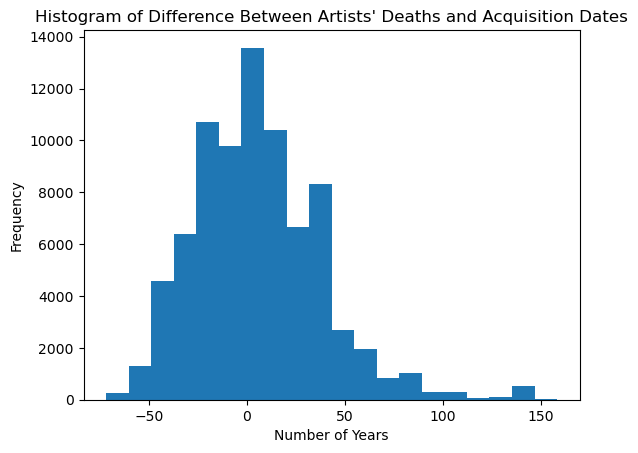

In [33]:
# visualize distribution of differences in a histogram
df['Num_Years'].plot(kind = 'hist', bins = 20)
# add title and axis labels
plt.title('Histogram of Difference Between Artists\' Deaths and Acquisition Dates')
plt.xlabel('Number of Years')
plt.ylabel('Frequency')
# show plot
plt.show()

**On average, MoMA acquires an artist's work about 5.5 years after their death. This is clear in the histogram, as the primary peak is slightly right of zero. The overall shape is slightly right skewed, as some acquisitions took place nearly 150 years after the artist's death and it is not possible for an acquisition to take place 150 years before an artist's death. A smaller peak is present around 40 years, possibly reflecting delayed recognition or interest in certain artists. This distribution shows that MoMA tends to acquire work around the time of an artist's death, but also expands its collection with works by artists who gain significance over time.**

I found it interesting that artwork seems to be acquired around the time of the artists death. So, I decided to zoom in on the ten years before and after their deaths to see if there was a pattern.

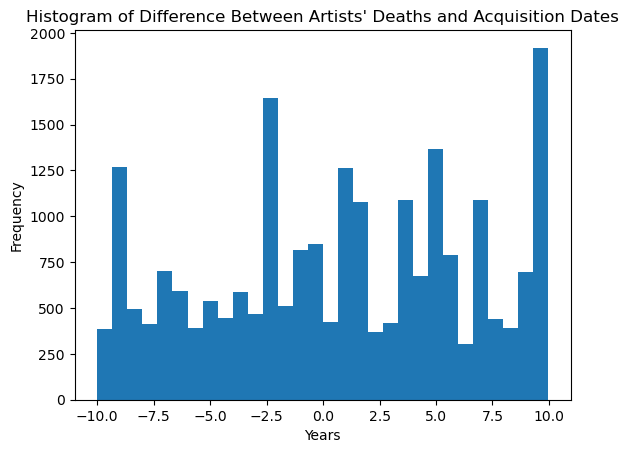

In [34]:
# filter the df to include only rows where the art was acquired within 10 years of artist's death
df_filtered = df[(df['Num_Years'] >= -10) & (df['Num_Years'] <= 10)]
# visualize the filtered df with a histogram
df_filtered['Num_Years'].plot(kind = 'hist', bins = 30)
# add title and axis labels
plt.title('Histogram of Difference Between Artists\' Deaths and Acquisition Dates')
plt.xlabel('Years')
plt.ylabel('Frequency')
# show plot
plt.show()

**To explore the peak around the time of an artist's death, I created this histogram showing the frequencies of artworks being acquired within the ten years before or after an artist's death. This did not reveal a clear pattern, with the frequencies of acquisitions varying seemingly randomly across this time frame. The lack of a pattern here suggests that MoMA's acquisition decisions are not closely tied to the timing of an artist's death.**

**How long after a piece is created does the museum typically acquire it?**

To answer this question, I took a similar approach to the question about the difference between an artist's death and the museum acquiring their work. I changed Year Created to a date by making it the last date of that year. I then found the difference between Acquisition Date and the new column, Full Creation Date, that I made. Since this difference was in days, I added a column converting it to years to make it more interpretable. 

In [35]:
# change Creation Date to type date
df['Full Creation Date'] = pd.to_datetime(df['Year Created'].apply(
    lambda x: f"{int(float(x))}-12-31" if pd.notna(x) and str(x).strip().isdigit() else np.nan
), errors='coerce')
# get difference between Acquisition Date and Full Creation Date
df['Diff_Acq_Creation'] = df['Acquisition Date'] - df['Year Created']
# since the difference is in days, get number of years
df['Num_Years_Acq_Creation'] = df['Diff_Acq_Creation'].dt.days / 365.25

I answered this question by finding the average number of years between the artwork being created and the museum acquiring it. Again, I did this to get a single, interpretable metric to summarize the pattern in the data.

In [36]:
# get average
print(f"On average, the MOMA acquires artworks {np.mean(df['Num_Years_Acq_Creation']):.2f} years after they are created.")

On average, the MOMA acquires artworks 29.09 years after they are created.


I visualized the distributuion of this statistic with a histogram.

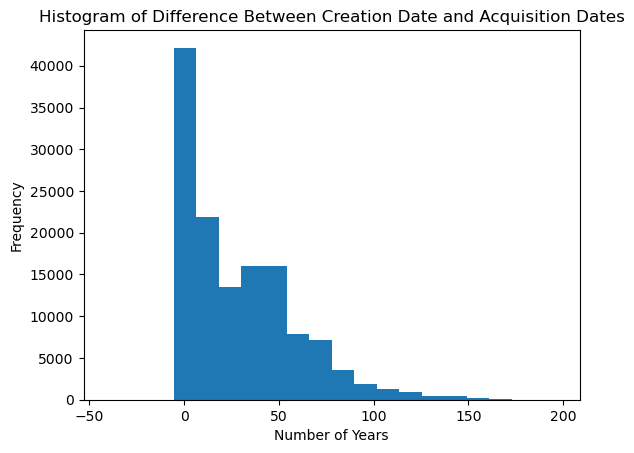

In [37]:
# visualize distribution of differences in a histogram
df['Num_Years_Acq_Creation'].plot(kind = 'hist', bins = 20)
# add title and axis labels
plt.title('Histogram of Difference Between Creation Date and Acquisition Dates')
plt.xlabel('Number of Years')
plt.ylabel('Frequency')
# show plot
plt.show()

**The average time between when a work is created and when it is acquired by MoMA is about 29 years. This distribution is highly right skewed, as acquisition cannot happen before a pieces is created. This histogram shows the peak being in the first bar, indicating that many works are acquired shortly after they are created, followed by a long tail of works acquired decades later. This suggests that MoMA frequently acquires works soon after they are made, but also adds historical pieces over time.**

Based on the average differences between acquisition date, creation date, and death dates and the distributions of creation dates and death dates, these metrics do not seem to explain the spike of artworks acquired in the 1960s.

**What caused the spike of acquisitions in artworks by French artists, male artists, and in albumen silver print pieces in the 1960s?**

The primary focus of this analysis is to find the reason behind the huge spike in acquisitions from male artists in the 1960s. The first thing I decided to focus on was the spike in acquiring albumen silver prints. 

I started this investigation by creating a data frame of artwork with a medium of Albumen silver print. I checked the shape to see how many artworks fit this criteria to know if it was a valid explanation for the spike. 

In [38]:
# create a df of only albumen silver print works
albumen_df = df[df['Medium']=='Albumen silver print']
# check shape
albumen_df.shape

(4953, 22)

This is clear from the mediums chart, but does not offer a good explanation for the spikes in the male artist and French artist acquisitions, as those spikes are much larger than about 5000 artworks. Nevertheless, I wanted to confirm that most albumen silver prints were created by male and French artists to see if the acquisition of this medium could explain part of those spikes. I checked these possibilities by creating a similar line plots to the gender and nationality plots of the overall data frame.

Text(0.5, 0, 'Decade')

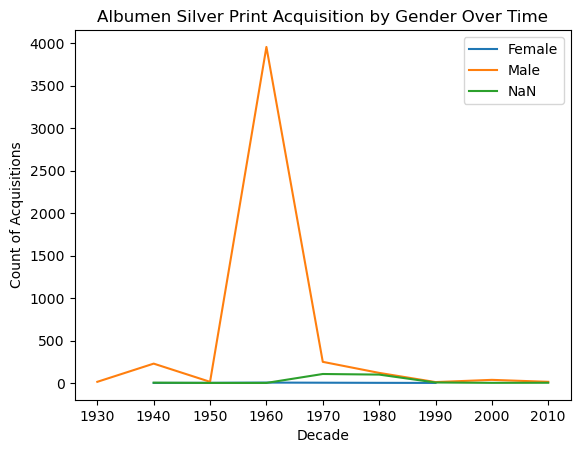

In [39]:
# create a df of counts of albumen silver print pieces by female artists acquired each decade
female_albumen_trend = albumen_df[albumen_df['Gender'] == 'Female'].groupby(['Acquisition Decade']).size().reset_index()
# rename count column to Female
female_albumen_trend.rename(columns = {0: 'Female'}, inplace = True)
# create a df of counts of albumen silver print pieces by male artists acquired each decade
male_albumen_trend = albumen_df[albumen_df['Gender'] == 'Male'].groupby(['Acquisition Decade']).size().reset_index()
# rename count column to Male
male_albumen_trend.rename(columns = {0: 'Male'}, inplace = True)
# create a df of counts of albumen silver print pieces by NaN/unknown gender artists acquired each decade
nan_albumen_trend = albumen_df[albumen_df['Gender'] == 'NaN'].groupby(['Acquisition Decade']).size().reset_index()
# rename count column to NaN
nan_albumen_trend.rename(columns = {0: 'NaN'}, inplace = True)
# plot female data and add title
first_plot = female_albumen_trend.plot(x = 'Acquisition Decade', y = 'Female', title = 'Albumen Silver Print Acquisition by Gender Over Time')
# set y axis label
first_plot.set_ylabel('Count of Acquisitions')
# plot male data onto female plot
male_albumen_trend.plot(x = 'Acquisition Decade', y = 'Male', ax = first_plot)
# plot nan data onto female plot
nan_albumen_trend.plot(x = 'Acquisition Decade', y = 'NaN', ax = first_plot)
# set x axis label
first_plot.set_xlabel('Decade')

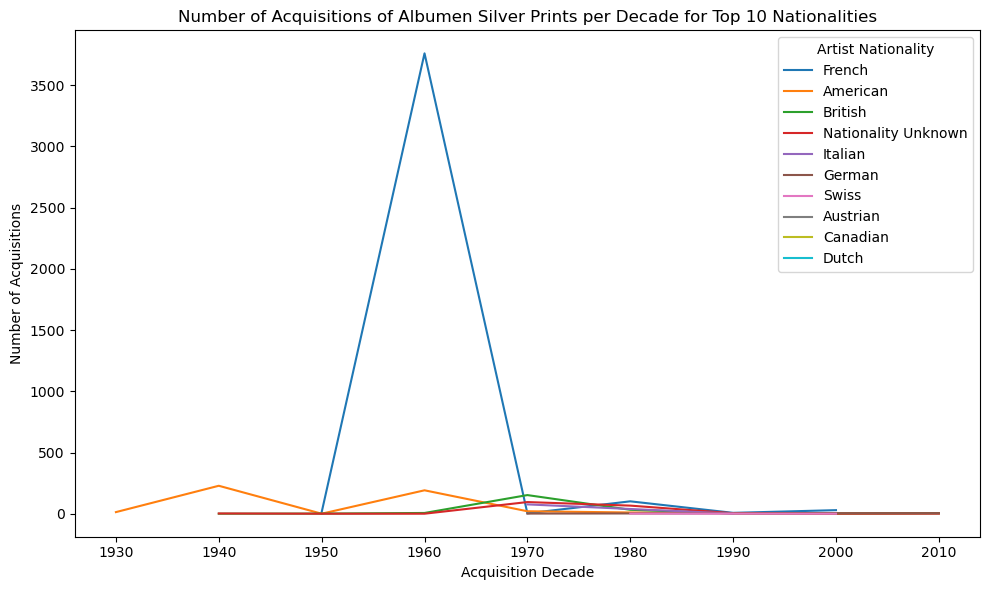

In [40]:
# get number of albumen silver print acquisitions by nationality
albumen_by_nationality = albumen_df.groupby(['Nationality', 'Acquisition Decade']).size().reset_index(name = 'Num_Acquisitions')
# get top 10 nationalities overall
top_10_nat_albumen = albumen_by_nationality.groupby('Nationality')['Num_Acquisitions'].sum().nlargest(10).index
# filter acqs_by_nationality to only include top 10 nationalities
filtered_albumen = albumen_by_nationality[albumen_by_nationality['Nationality'].isin(top_10_nat)]
# plot
plt.figure(figsize = (10,6))
# for each of the top 10 nationalities, plot the data in a line plot
for nationality in top_10_nat_albumen:
    nat_data = filtered_albumen[filtered_albumen['Nationality'] == nationality]
    plt.plot(nat_data['Acquisition Decade'], nat_data['Num_Acquisitions'], label = nationality)
# add title, legend, and axis labels
plt.title('Number of Acquisitions of Albumen Silver Prints per Decade for Top 10 Nationalities')
plt.xlabel('Acquisition Decade')
plt.ylabel('Number of Acquisitions')
plt.legend(title = 'Artist Nationality')
# show plot
plt.tight_layout()
plt.show()

It is clear that the majority of albumen silver prints were created by French male artists, particularly the pieces acquired in the 1960s.

In [41]:
# compare differences of acquisition date with artist's death and creation date with rest of df
print(f"The mean number of years between an artist's death and the MOMA acquiring their albumen silver print is {np.mean(albumen_df['Num_Years']):.2f}")
print(f"The mean number of years between an albumen silver print being created and the MOMA acquiring it is {np.mean(albumen_df['Num_Years_Acq_Creation']):.2f}")

The mean number of years between an artist's death and the MOMA acquiring their albumen silver print is 45.70
The mean number of years between an albumen silver print being created and the MOMA acquiring it is 69.97


These averages are both much higher than the averages for the collection as a whole, but do not offer a clear reason for the spike.

Since my analysis of creation dates and artist's death years for the albumen silver prints did not yield an insightful explanation for the spike, I decided to take a closer look at the work that was acquired in the 1960s, not just the albumen silver prints. I began this process by creating a data frame of artworks acquired in the 1960s.

In [42]:
# since focus is on spike in 1960s, create df of work acquired in 1960s
acq_1960 = df[df['Acquisition Decade'] == 1960]

Because the albumen silver prints did not fully account for the spike in the 1960s, I created a bar chart of the top 10 mediums acquired from that decade to see if any other mediums stood out.

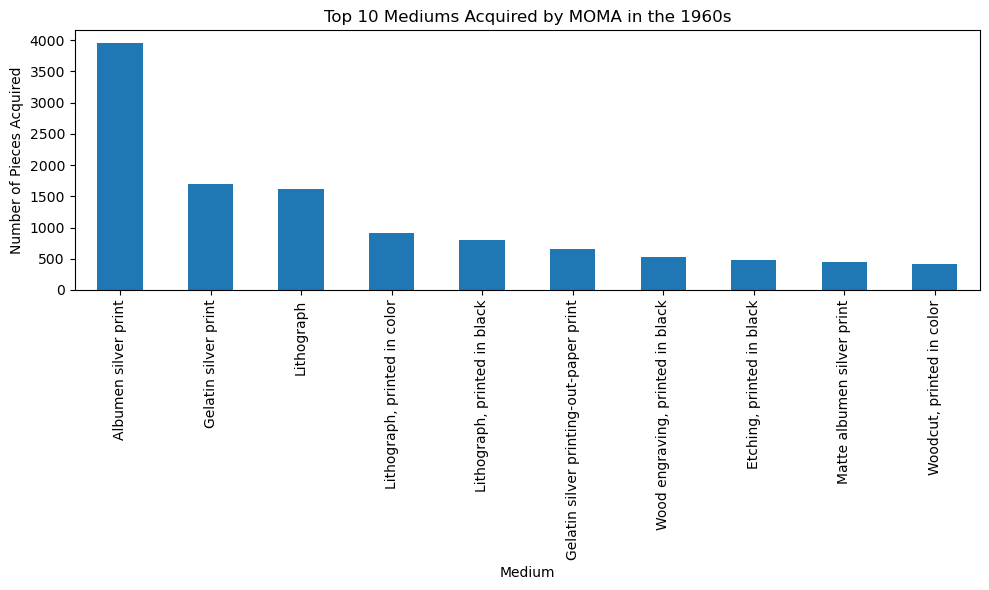

In [43]:
# create a df of top 10 mediums acquired in the 1960s
medium_counts_1960 = acq_1960['Medium'].value_counts().nlargest(10)
# plot data as a bar chart
plt.figure(figsize=(10, 6))
medium_counts_1960.plot(kind='bar')
# add title and axis lables
plt.xlabel('Medium')
plt.ylabel('Number of Pieces Acquired')
plt.title('Top 10 Mediums Acquired by MOMA in the 1960s')
# rotate x axis labels for readability
plt.xticks(rotation=90)
# show plot
plt.tight_layout()
plt.show()

An important thing to note from this plot is that albumen silver prints and gelatin silver prints (the top 2 most acquired mediums of the 1960s) are both types of photographs. Gelatin silver printing-out-paper print (the sixth bar) is also a type of photogrpahy. This suggests MoMA was focused on growing their photography collection, rather than growing their collection of artworks by French male artists.

To test this theory, I checked the distribution of genders and nationalities among albumen silver print and gelatin silver print artists. I did this in a single bar chart for easy comparison between gender-nationality combinations.

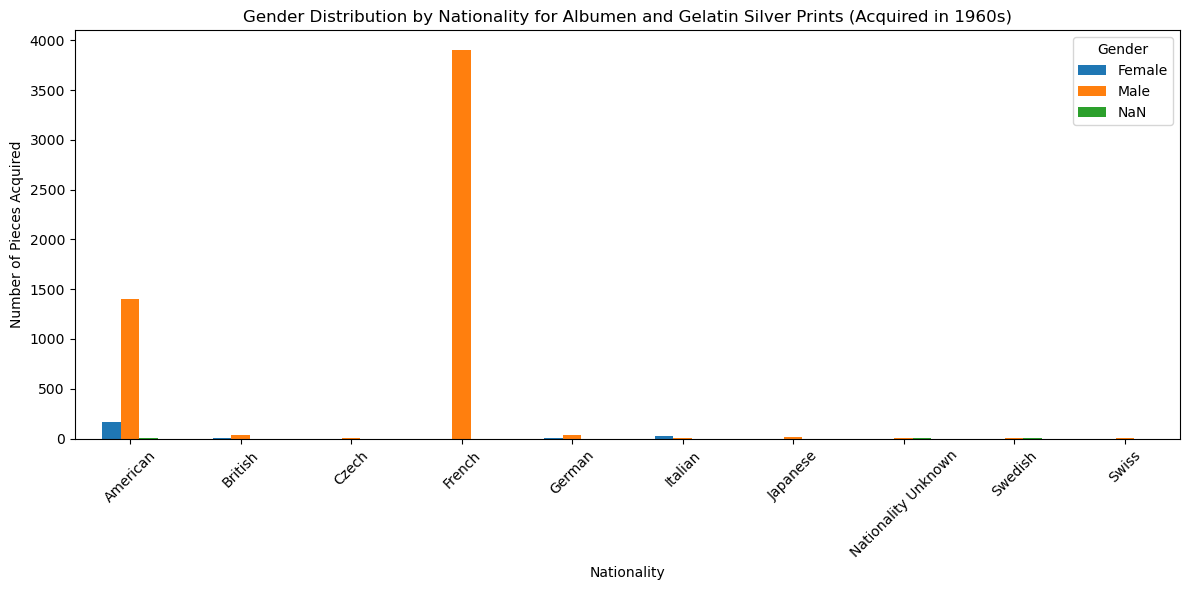

In [44]:
# filter work acquired in the 1960s to only top two mediums (both are types of photography)
prints_1960 = acq_1960[(acq_1960['Medium'] == "Albumen silver print") | (acq_1960['Medium'] == "Gelatin silver print")]
# get top 10 nationalities
top_nationalities = prints_1960['Nationality'].value_counts().nlargest(10).index
# filter prints_1960 to only include top 10 nationalities
prints_top_nat = prints_1960[prints_1960['Nationality'].isin(top_nationalities)]
# get counts for each nationality/gender combo
grouped = prints_top_nat.groupby(['Nationality', 'Gender']).size().unstack(fill_value=0)
# plot data in bar chart
grouped.plot(kind='bar', figsize=(12, 6))
# add title and axis labels
plt.xlabel('Nationality')
plt.ylabel('Number of Pieces Acquired')
plt.title('Gender Distribution by Nationality for Albumen and Gelatin Silver Prints (Acquired in 1960s)')
# rotate x axis labels for readability
plt.xticks(rotation=45)
# show plot
plt.tight_layout()
plt.show()

It is clear that when looking at both prints, most were created by French and American male aritsts. It also seems more plausible that this could explain the spike in the 1960s since more of those pieces are accounted for under the theory of acquiring more photography. The next step was to see if removing these types of mediums removed the spike from the 1960s. I created a data frame with the artworks of these mediums only from the 1960s removed, rather than all pieces of those mediums, in order to isolate the impact of those mediums in that decade. If I had removed these mediums from all decades, I would have lost the historical context of their presence in the collection over time.

In [45]:
# create a df with pieces of those mediums acquired in the 1960s removed
df_no_prints = df[~((df['Medium'].isin(["Albumen silver print", "Gelatin silver print"])) & (df['Acquisition Decade'] == 1960))]

I checked the differences in the lengths of the data frame and the data frame with these pieces removed. There was difference of about 6000, which is significant, but not enough to completely explain the spikes.

In [46]:
# compare shapes to check if it worked
print(df_no_prints.shape)
print(df.shape)

(136628, 22)
(142281, 22)


I created a line chart of the data frame with the prints from the 1960s removed to see how much the spike in male artists was reduced.

Text(0.5, 0, 'Decade')

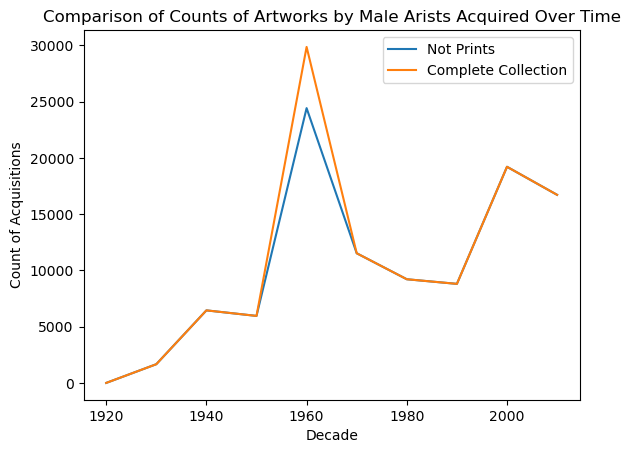

In [47]:
# create a df of counts of non-print pieces by male artists acquired each decade
male_acq_trend_no_prints = df_no_prints[df_no_prints['Gender'] == 'Male'].groupby(['Acquisition Decade']).size().reset_index()
# rename count column to Not From Stern Collection
male_acq_trend_no_prints.rename(columns = {0: 'Not Prints'}, inplace = True)
# create a df of counts of pieces by male artists acquired each decade
male_acq_trend = df[df['Gender'] == 'Male'].groupby(['Acquisition Decade']).size().reset_index()
# rename count column to Complete Collection
male_acq_trend.rename(columns = {0: 'Complete Collection'}, inplace = True)
# plot non-print data and add a title
first_plot = male_acq_trend_no_prints.plot(x = 'Acquisition Decade', y = 'Not Prints', title = 'Comparison of Counts of Artworks by Male Arists Acquired Over Time')
# set y axis label
first_plot.set_ylabel('Count of Acquisitions')
# plot male data onto female plot
male_acq_trend.plot(x = 'Acquisition Decade', y = 'Complete Collection', ax = first_plot)
# set x axis label
first_plot.set_xlabel('Decade')

The spike was reduced somewhat, but not entirely, so it is clear that expanding the photography collection was not the only reason for the huge acquirement of artworks in the 1960s.

Since my previous theory was not entirely correct, I decided to visualize the top 10 nationalities represented in the 1960s to see if that would shed light on why there was such a huge spike.

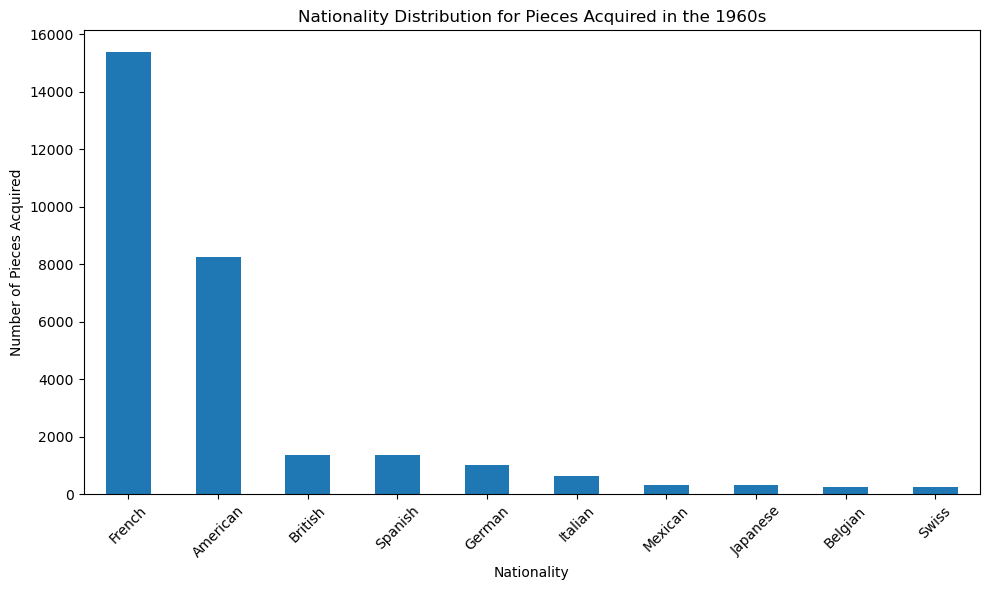

In [48]:
# create new df to visualize counts of top 10 nationalities represented in works acquired in the 1960s
acq_1960_nat = acq_1960['Nationality'].value_counts().nlargest(10)
# plot the data in a bar chart
plt.figure(figsize = (10,6))
acq_1960_nat.plot(kind = "bar")
# add title and axis labels
plt.xlabel('Nationality')
plt.ylabel('Number of Pieces Acquired')
plt.title('Nationality Distribution for Pieces Acquired in the 1960s')
# rotate x axis labels for readability
plt.xticks(rotation=45)
# show plot
plt.tight_layout()
plt.show()

The vast majority of artworks acquired in the 1960s were by French and American artists, regardless of medium.

I then had the idea that perhaps the artwork came from a large number of donations in that time period. I checked the number of artworks from the top five donations in the 1960s.

In [49]:
# check counts of sources of pieces acquired in the 1960s
acq_1960['Source'].value_counts().sort_values(ascending = False).head()

The Louis E. Stern Collection                                11181
Abbott-Levy Collection. Partial gift of Shirley C. Burden     4889
Purchase                                                      1060
Gift of Kleiner, Bell & Co.                                    979
Gift of Mr. and Mrs. Ralph F. Colin                            871
Name: Source, dtype: int64

I thought that was a shocking number of artworks from the Louis E. Stern Collection. I did not know if this was a normal amount of artworks to donate, so I compared the number of donations from the greatest donation of each decade.

In [50]:
# check what the greatest number of pieces from a single source was each decade
top_sources_per_decade = (
    df.groupby('Acquisition Decade')['Source']
      .value_counts()
      .groupby(level=0)
      .head(1)
      .reset_index(name='Count')
)
top_sources_per_decade

,Acquisition Decade,Source,Count
0,1920.0,Gift of Paul J. Sachs,9
1,1930.0,Gift of Abby Aldrich Rockefeller,348
2,1940.0,Gift of Abby Aldrich Rockefeller,1450
3,1950.0,Purchase,802
4,1960.0,The Louis E. Stern Collection,11181
5,1970.0,"Gift of Kleiner, Bell & Co.",1286
6,1980.0,Purchase,1085
7,1990.0,Gift of the artist,1399
8,2000.0,The Gilbert and Lila Silverman Fluxus Collecti...,4222
9,2010.0,Gift of the Roy Lichtenstein Foundation in hon...,1637


The donation from the Louis E. Stern Collection is by far the largest donation, and is likely the reason for the spike in the 1960s.

To test this idea, I created a data frame of only artworks from the Louis E. Stern collection.

In [51]:
# create a new df of pieces only from the louis e stern collection
stern_df = df[(df['Source'] == 'The Louis E. Stern Collection')]

It is important to recall that the way I set up the data frame means there could be several rows for one piece. Although I wanted to maintain the focus of my analysis on volume representation, since the donation from the Stern Collection was so much larger than any other donation, I wanted to confirm that there were truly that many pieces. I checked this by comparing the number of rows in the stern data frame to the number of unique Artwork IDs.

In [52]:
# see if each artwork id is unique
print(f"There are {stern_df['Artwork ID'].unique().shape[0]} unique pieces from the Stern Collection.")
print(f"The stern data frame has {stern_df.shape[0]} rows.")

There are 10926 unique pieces from the Stern Collection.
The stern data frame has 11187 rows.


There are only about 200 duplicated pieces and compared to the magnitude of the spike, this is nearly negligible so I decided to continue with the analysis and not alter my representation volume approach.

I then checked the counts of artworks by gender and nationality to compare to the previous counts.

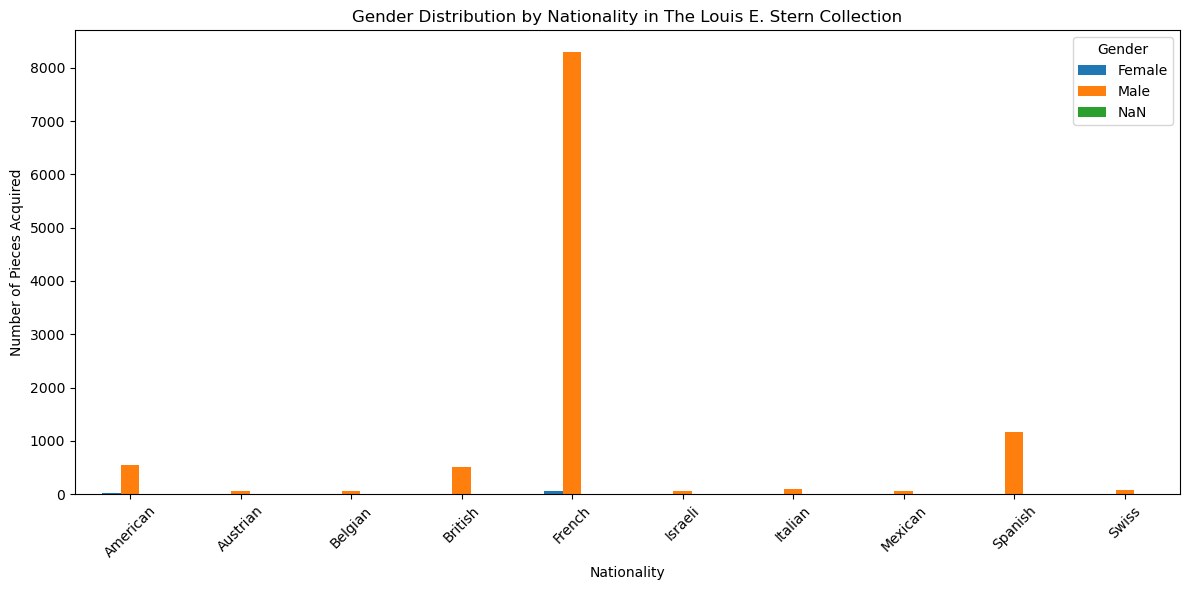

In [53]:
# get top 10 nationalities in stern collection
top_stern_nats = stern_df['Nationality'].value_counts().nlargest(10).index
# filter stern_df to only include top 10 nationalities
stern_top_nat = stern_df[stern_df['Nationality'].isin(top_stern_nats)]
# get counts for each gender/nationality combo
stern_grouped = stern_top_nat.groupby(['Nationality', 'Gender']).size().unstack(fill_value=0)
# plot data in bar chart
stern_grouped.plot(kind='bar', figsize=(12, 6))
# add title and axis labels
plt.xlabel('Nationality')
plt.ylabel('Number of Pieces Acquired')
plt.title('Gender Distribution by Nationality in The Louis E. Stern Collection')
# rotate x axis labels for readability
plt.xticks(rotation=45)
# show plot
plt.tight_layout()
plt.show()

The largest demographic group represented is French male artists by far! This looks promising as an explanation for the spike. I started to confirm this by creating a data frame of artworks not from the Louis E. Stern Collection.

In [54]:
# create a df of all artwork that did not come from the louis e stern collection
no_stern_df = df[(df['Source'] != 'The Louis E. Stern Collection')]

I created a line plot to visualize the acquisition of art by gender over time, with the work from the Stern Collection removed.

Text(0.5, 0, 'Decade')

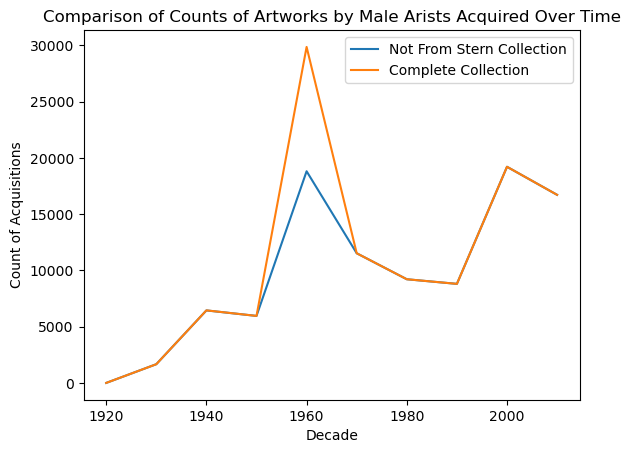

In [55]:
# create a df of counts of pieces by male artists acquired each decade that were not from the stern collection
male_acq_trend_no_stern = no_stern_df[no_stern_df['Gender'] == 'Male'].groupby(['Acquisition Decade']).size().reset_index()
# rename count column to Not From Stern Collection
male_acq_trend_no_stern.rename(columns = {0: 'Not From Stern Collection'}, inplace = True)
# create a df of counts of pieces by male artists acquired each decade
male_acq_trend = df[df['Gender'] == 'Male'].groupby(['Acquisition Decade']).size().reset_index()
# rename count column to Complete Collection
male_acq_trend.rename(columns = {0: 'Complete Collection'}, inplace = True)
# plot non-stern data and add a title
first_plot = male_acq_trend_no_stern.plot(x = 'Acquisition Decade', y = 'Not From Stern Collection', title = 'Comparison of Counts of Artworks by Male Arists Acquired Over Time')
# set y axis label
first_plot.set_ylabel('Count of Acquisitions')
# plot male data onto female plot
male_acq_trend.plot(x = 'Acquisition Decade', y = 'Complete Collection', ax = first_plot)
# set x axis label
first_plot.set_xlabel('Decade')

There was still much more artwork acquired in the 1960s than in almost any other decade, but the spike had been reduced significantly.

I then wanted to analyze the data based on the two theories I had had so far: the spike in the 1960s could be largely attributed to (1) MoMA was expanding its photography collection and (2) the donation from the Stern Collection.

I created a data frame of all of the artworks with the four most popular types of prints from the 1960s removed as well as artwork from the Stern Collection. Again, I only removed these mediums from the 1960s to isolate their impact in that decade and to not remove their historical context overall.

In [56]:
# create a df that exclude pieces from the stern collection or is a print type of photography
df_no_prints_or_stern = df[~(((df['Medium'].isin(["Albumen silver print", "Gelatin silver print", "Matte albumen silver print", "Gelatin silver printing-out-paper print"]))  & (df['Acquisition Decade'] == 1960)) | (df['Source'] == 'The Louis E. Stern Collection'))]

I created a line chart of counts by of artworks by male artists that compares the data from the entire collection to the counts from this filtered data frame to easily compare how much the spike was reduced by removing the prints and the items from the Stern Collection.

Text(0.5, 0, 'Decade')

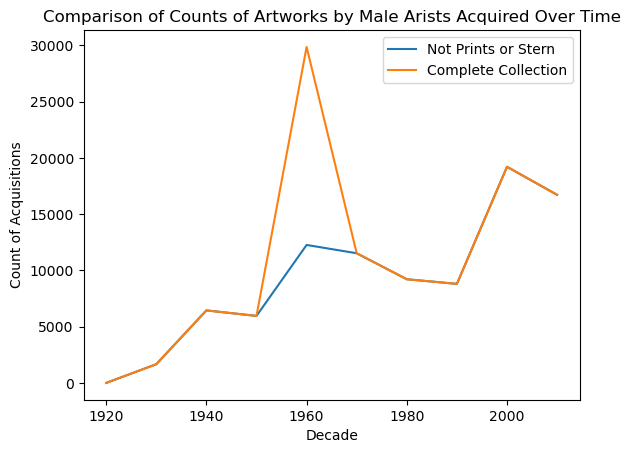

In [57]:
# create a df of counts of non-print pieces by male artists acquired each decade that were not from the stern collection
male_acq_trend_no_prints_or_stern = df_no_prints_or_stern[df_no_prints_or_stern['Gender'] == 'Male'].groupby(['Acquisition Decade']).size().reset_index()
# rename count column to Not Prints or Stern
male_acq_trend_no_prints_or_stern.rename(columns = {0: 'Not Prints or Stern'}, inplace = True)
# create a df of counts of pieces by male artists acquired each decade
male_acq_trend = df[df['Gender'] == 'Male'].groupby(['Acquisition Decade']).size().reset_index()
# rename count column to Complete Collection
male_acq_trend.rename(columns = {0: 'Complete Collection'}, inplace = True)
# plot non-print data and add a title
first_plot = male_acq_trend_no_prints_or_stern.plot(x = 'Acquisition Decade', y = 'Not Prints or Stern', title = 'Comparison of Counts of Artworks by Male Arists Acquired Over Time')
# set y axis label
first_plot.set_ylabel('Count of Acquisitions')
# plot male data onto female plot
male_acq_trend.plot(x = 'Acquisition Decade', y = 'Complete Collection', ax = first_plot)
# set x axis label
first_plot.set_xlabel('Decade')

The spike was significantly reduced! It is now less than half of what it originally was.

I also created a line plot of counts by nationality to compare to previous plots with the huge spike in French artists.

Text(0.5, 0, 'Decade')

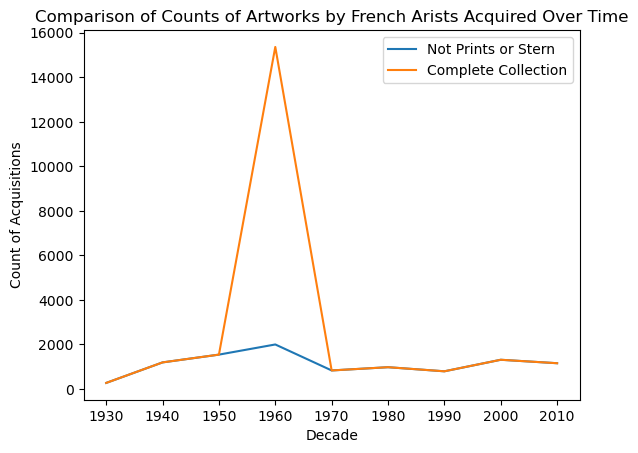

In [58]:
# create a new df to get number of non-print acquisitions not from stern collection by nationality
acqs_by_nationality_no_prints_or_stern = df_no_prints_or_stern.groupby(['Nationality', 'Acquisition Decade']).size().reset_index(name = 'Not Prints or Stern')
# get top 10 nationalities overall from this df
top_10_nat_no_prints_or_stern = acqs_by_nationality_no_prints_or_stern.groupby('Nationality')['Not Prints or Stern'].sum().nlargest(10).index
# filter acqs_by_nationality to only include top 10 nationalities
filtered_acqs_no_prints_or_stern = acqs_by_nationality_no_prints_or_stern[acqs_by_nationality_no_prints_or_stern['Nationality'] == "French"]
# get number of acquisitions by nationality each decade
acqs_by_nationality = df.groupby(['Nationality', 'Acquisition Decade']).size().reset_index(name = 'Complete Collection')
# get top 10 nationalities overall
top_10_nat = acqs_by_nationality.groupby('Nationality')['Complete Collection'].sum().nlargest(10).index
# filter acqs_by_nationality to only include top 10 nationalities
filtered_acqs = acqs_by_nationality[acqs_by_nationality['Nationality'] == "French"]
# plot non-print data and add a title
first_plot = filtered_acqs_no_prints_or_stern.plot(x = 'Acquisition Decade', y = 'Not Prints or Stern', title = 'Comparison of Counts of Artworks by French Arists Acquired Over Time')
# set y axis label
first_plot.set_ylabel('Count of Acquisitions')
# plot male data onto female plot
filtered_acqs.plot(x = 'Acquisition Decade', y = 'Complete Collection', ax = first_plot)
# set x axis label
first_plot.set_xlabel('Decade')

The spike in French artists is nearly completely gone! The acquired artworks of French artists in the 1960s was almost entirely due to the expansion of the photogrpahy collection and the Stern donation.

To confirm that there was an unsual amount of acquisition of photography pieces, I created a line chart showing the total count of print pieces acquired each decade. I included more types of prints here (chromogenic print and inkjet print) to account for the aquirement of more modern types of prints.

In [59]:
# create a df of all types of prints
prints_over_time = df[(df['Medium'].str.contains("silver print", case=False, na=False)) | (df['Medium'].str.contains("platinum print", case=False, na=False)) | (df['Medium'].str.contains("chromogenic print", case=False, na=False)) | (df['Medium'].str.contains("inkjet print", case=False, na=False))]

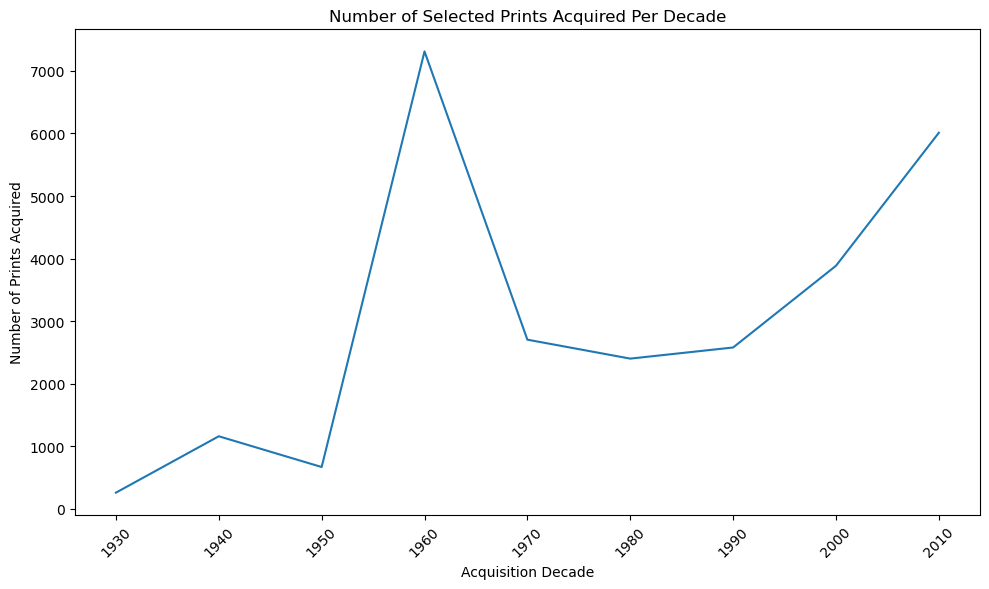

In [60]:
# create a df of number of prints (any type) acquired each decade
prints_by_decade = prints_over_time.groupby('Acquisition Decade').size()
# plot data in line chart
plt.figure(figsize=(10, 6))
prints_by_decade.plot()
# add title and axis labels
plt.xlabel('Acquisition Decade')
plt.ylabel('Number of Prints Acquired')
plt.title('Number of Selected Prints Acquired Per Decade')
# rotate x axis labels for readability
plt.xticks(rotation=45)
# show plot
plt.tight_layout()
plt.show()

This confirms there was a huge spike in acquiring prints in the 1960s with a slower increase beginning in the 1980s. MoMA began collecting photography in the 1930s and the photography department was founded in the 1940s, so it makes sense it would focus on expanding its photography collection soon after being founded.

**Conclusion**

This analysis examines the Museum of Modern Art's (MoMA) acquisition patterns to better understand how the collection reflects demographic representation and how those patterns have evolved over time. The study focuses on artists' gender and nationality, acquisition trends by decade, creation dates of artworks, artistic mediums, and the timing of acquisition in relation to both the creation of the piece and the artist's death.

**To what extent does the collection feature artworks created by artists of different genders and nationalities?**

The MoMA collection is primarily composed of artworks by male artists, who are significantly better represented than female artists and artists with unknown gender. In terms of nationality, American artists are represented best, followed by French, German, British, and artists of unknown nationality. Among women, American artists are the most represented. There is a noteable overlap between unknown gender and unknown nationality, indication many works by unidentified artists.

**How have these demographics changed over time (by acquisition decade)?**

Across all decades, artworks by male artists are consistently acquired at a higher rate than those by female artists and artists of unknown gender. The 1960s makred a sharp spike in acquisitions by male artists, with another noteable increase in the 2000s. While acquisitions of artworks by female artists and those with uknown gender follow similar trends, they remain at consistently lower levels. In every decade except for the 1960s, artworks by American artists were the most frequently acquired. In the 1960s, there was a significant spike in the acquisition of pieces by French artists. This anomaly matched a spike in albumen silver print photography pieces, many of which came from a single donation (the Louis E. Stern collection) and the museum's focus on expanding its photography collection.

**What is the distribution of creation dates in this collection?**

The majority of the artworks in the collection were created in the 20th century, with particularly high frequencies around the 1920s, 1960s, and 2010s. The distribution of creation dates is left skewed, emphasizing MoMA's focus on modern and contemporary art, with fewer pieces from the 1800s.

**How have the mediums acquired by the museum changed over time?**

Until the 1950s, MoMA's acquisition of different mediums followed similar trends. In the 1960s, there was a sharp spike in the acquisition of albumen silver prints, driving corresponding spikes in the acquisition of artworks by French and male artists in that decade. This was followed by a decline, while gelatin silver prints and lithographs became more frequently acquired after the 1980s. This reflects the evolving artistic trends and changes in MoMA's acquisitional focus.

**How long after an artist's death does the museum typically acquire their work?**

On average, MoMA acquires an artist's work about 5.5 years after their death, though this can range up to 150 years. Acquisitions tend to occur shortly before and after death, with another peak about 40 years after death, possibly indicating delayed recognition or popularity.

**How long after a piece is created does the museum typically acquire it?**

The average time between an artwork's creation date and acquisition date is about 29 years. While many pieces are acquired shortly after being made, a right-skewed distribution shows MoMA's efforts to include significant historical pieces.

**What caused the spike of acquisitions in artworks by French artists, male artists, and in albumen silver print pieces in the 1960s?**

The sharp increase in acquisitions by French and male artists in the 1960s can be largely attributed to two factors. The first is the expansion of MoMA's photography collection a couple decades after its creation, which is also ther reason for the spike in albumen silver print artworks. The second is a huge donation from the Louis E. Stern Collection, with a large concentration of works by French male artists that drove the demographic spikes. So, the 1960s spike was not caused by a specific focus by the museum on these types of artworks and artists, but rather these two factors.

**I worked alone so I did each part of this analysis.**